**90% DE LOS COMENTARIOS GENERADOS CON AYUDA DE IA**

In [1]:
# Basics
import os  # Operating system operations
import shutil  # File operations (copy, move)
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# TensorFlow/Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Augmented data generators
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization  # Neural network layers
from tensorflow.keras.models import Sequential  # Sequential model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Callbacks for training
from tensorflow.keras.optimizers import Adam  # Optimizer

2025-05-13 18:19:37.256145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 18:19:37.257258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 18:19:37.260764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 18:19:37.269825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747160377.284850   42746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747160377.28

In [2]:
# Warnings settings
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings for a cleaner exit

In [3]:
# Organizing images into folders by class
directory = "../data/raw/train"  # Path to the training directory

def organize(path):
    # Create subdirectories for cats and dogs
    os.makedirs(f"{path}/cats", exist_ok=True)
    os.makedirs(f"{path}/dogs", exist_ok=True)
    
    # Get list of files in directory
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Move each file to the corresponding folder according to its name
    for name in files:
        if "cat" in name:
            shutil.move(f"{path}/{name}", f"{path}/cats/{name}")
        elif "dog" in name:
            shutil.move(f"{path}/{name}", f"{path}/dogs/{name}")

organize(directory)

In [4]:
# Configuring the data generator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values ​​to [0,1]
    rotation_range=15,  # Random rotation up to 15 degrees
    width_shift_range=0.1,  # Random horizontal shift (10% of width)
    height_shift_range=0.1,  # Random vertical shift (10% of height)
    shear_range=0.1,  # Random shear deformation
    zoom_range=0.2,  # Random zoom up to 20%
    horizontal_flip=True,  # Random horizontal flip
    validation_split=0.2  # 20% of the data for validation
    )

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=(100, 100),  # Resize images to 100x100 pixels
    batch_size=32,  # Lot size
    class_mode="binary",  # Binary classification (cat vs dog)
    subset="training",  # Use as training subset
    seed=42  # Seed for reproducibility
)

# Generator for validation data
val_generator = train_datagen.flow_from_directory(
    directory, 
    target_size=(100, 100), 
    batch_size=32, 
    class_mode="binary", 
    subset="validation",  # Use as validation subset
    seed=42  # Same seed for consistency
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
# Display the automatically generated class mapping
train_generator.class_indices

{'cats': 0, 'dogs': 1}

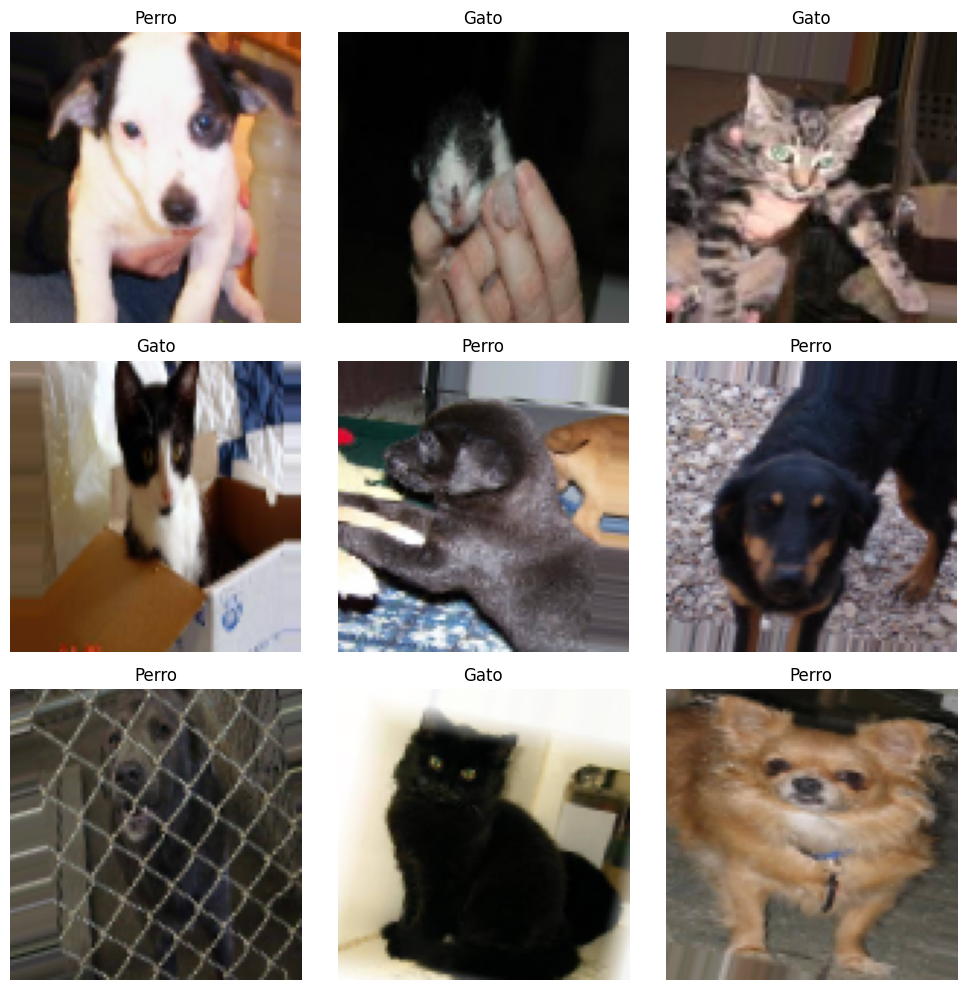

In [6]:
# Displaying a batch of training images with their labels
# Getting the first batch from the generator
images, labels = next(train_generator)

# Display 9 images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)  # Create 3x3 subplot
    plt.imshow(images[i])  # Show image
    label = 'Perro' if labels[i] == 1 else 'Gato'  # Convert numeric label to text
    plt.title(label)  # Show tag as title
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [7]:
# Model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), activation='relu'), 
#     BatchNormalization(), 
#     MaxPooling2D(pool_size=(2, 2)), 
#     Dropout(0.25),
#  
#     Conv2D(128, (3, 3), activation='relu'), 
#     BatchNormalization(), 
#     MaxPooling2D(pool_size=(2, 2)), 
#     Dropout(0.25), 
#     Flatten(),

#     Dense(512, activation='relu'), 
#     BatchNormalization(), 
#     Dropout(0.5), 
#     Dense(1, activation='sigmoid')
# ])

In [8]:
# Load a pre-trained model instead of defining it from scratch
# The model achieved 88.98% validation accuracy

from tensorflow.keras.models import load_model

# Cargar el modelo guardado previamente
model = load_model("best_model.h5")

2025-05-13 18:19:44.853943: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Compile the model
model.compile(
    optimizer="adam",  # Adam optimizer (a variant of gradient descent)
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metric to monitor: accuracy
)

In [10]:
# Configuring training callbacks

# EarlyStopping: Stop training if there is no improvement in val_accuracy after 10 epochs
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)

# ModelCheckpoint: Save the best model according to val_accuracy
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max'  # Maximize monitored metrics
)

# ReduceLROnPlateau: Reduce learning rate when val_accuracy stagnates
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,  # Wait 2 periods without improvement
    verbose=1,
    factor=0.5,  # Reduce lr by half
    min_lr=0.000001  # Minimum learning rate
)

In [11]:
# Model training (fine-tuning)
# history = model.fit(
#     train_generator,  # Training data
#     epochs=40,  # Total number of epochs
#     initial_epoch=30,  # Initial period (to continue training)
#     validation_data=val_generator,  # Validation data
#     callbacks=[early_stop, checkpoint, reduce_lr]  # Configured callbacks
# )

In [12]:
# Evaluating the model on the validation set
_, accuracy = model.evaluate(val_generator)  # _ ignores loss
print(f"Accuracy en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - accuracy: 0.8807 - loss: 0.2656
Accuracy en validación: 0.89


In [13]:
# Setting up the generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalización, sin aumento

test_dir = "../data/raw/test1"
batch_size = 32  # Same batch size as training
target_size = (100, 100)  # Same size as in training

# Create generator for test data
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Maintain order to correlate with file names
)

Found 12500 images belonging to 1 classes.


In [14]:
# Make predictions on the test set
predictions = model.predict(test_generator) # Get prediction probabilities

391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step


In [15]:
# Organize test images in a subfolder (so that flow_from_directory works)
# Necessary because flow_from_directory expects a subfolder structure
os.makedirs("../data/raw/test1/mixed", exist_ok=True)
test_files = [f for f in os.listdir("../data/raw/test1") if os.path.isfile(os.path.join("../data/raw/test1", f))]
for file in test_files:
    shutil.move(f"../data/raw/test1/{file}", "../data/raw/test1/mixed")

In [16]:
# Convert prediction probabilities to classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Threshold at 0.5
class_labels = ["gato", "perro"]  # Labels corresponding to the classes
predicted_labels = [class_labels[i] for i in predicted_classes]  # Map to tags

In [17]:
# Getting file names from the test generator
filenames = test_generator.filenames

# Show ranking results
for filename, label in zip(filenames, predicted_labels):
    print(f"Imagen: {filename} -> Clase: {label}")

Imagen: mixed/1.jpg -> Clase: perro
Imagen: mixed/10.jpg -> Clase: gato
Imagen: mixed/100.jpg -> Clase: gato
Imagen: mixed/1000.jpg -> Clase: perro
Imagen: mixed/10000.jpg -> Clase: perro
Imagen: mixed/10001.jpg -> Clase: gato
Imagen: mixed/10002.jpg -> Clase: gato
Imagen: mixed/10003.jpg -> Clase: perro
Imagen: mixed/10004.jpg -> Clase: gato
Imagen: mixed/10005.jpg -> Clase: gato
Imagen: mixed/10006.jpg -> Clase: gato
Imagen: mixed/10007.jpg -> Clase: gato
Imagen: mixed/10008.jpg -> Clase: gato
Imagen: mixed/10009.jpg -> Clase: gato
Imagen: mixed/1001.jpg -> Clase: gato
Imagen: mixed/10010.jpg -> Clase: perro
Imagen: mixed/10011.jpg -> Clase: perro
Imagen: mixed/10012.jpg -> Clase: gato
Imagen: mixed/10013.jpg -> Clase: gato
Imagen: mixed/10014.jpg -> Clase: gato
Imagen: mixed/10015.jpg -> Clase: perro
Imagen: mixed/10016.jpg -> Clase: gato
Imagen: mixed/10017.jpg -> Clase: gato
Imagen: mixed/10018.jpg -> Clase: gato
Imagen: mixed/10019.jpg -> Clase: gato
Imagen: mixed/1002.jpg -> Cla


Imagen: mixed/11093.jpg -> Clase: perro
Imagen: mixed/11094.jpg -> Clase: gato
Imagen: mixed/11095.jpg -> Clase: gato
Imagen: mixed/11096.jpg -> Clase: perro
Imagen: mixed/11097.jpg -> Clase: perro
Imagen: mixed/11098.jpg -> Clase: gato
Imagen: mixed/11099.jpg -> Clase: gato
Imagen: mixed/111.jpg -> Clase: gato
Imagen: mixed/1110.jpg -> Clase: gato
Imagen: mixed/11100.jpg -> Clase: perro
Imagen: mixed/11101.jpg -> Clase: perro
Imagen: mixed/11102.jpg -> Clase: gato
Imagen: mixed/11103.jpg -> Clase: gato
Imagen: mixed/11104.jpg -> Clase: perro
Imagen: mixed/11105.jpg -> Clase: gato
Imagen: mixed/11106.jpg -> Clase: gato
Imagen: mixed/11107.jpg -> Clase: perro
Imagen: mixed/11108.jpg -> Clase: gato
Imagen: mixed/11109.jpg -> Clase: gato
Imagen: mixed/1111.jpg -> Clase: gato
Imagen: mixed/11110.jpg -> Clase: gato
Imagen: mixed/11111.jpg -> Clase: perro
Imagen: mixed/11112.jpg -> Clase: perro
Imagen: mixed/11113.jpg -> Clase: perro
Imagen: mixed/11114.jpg -> Clase: perro
Imagen: mixed/111

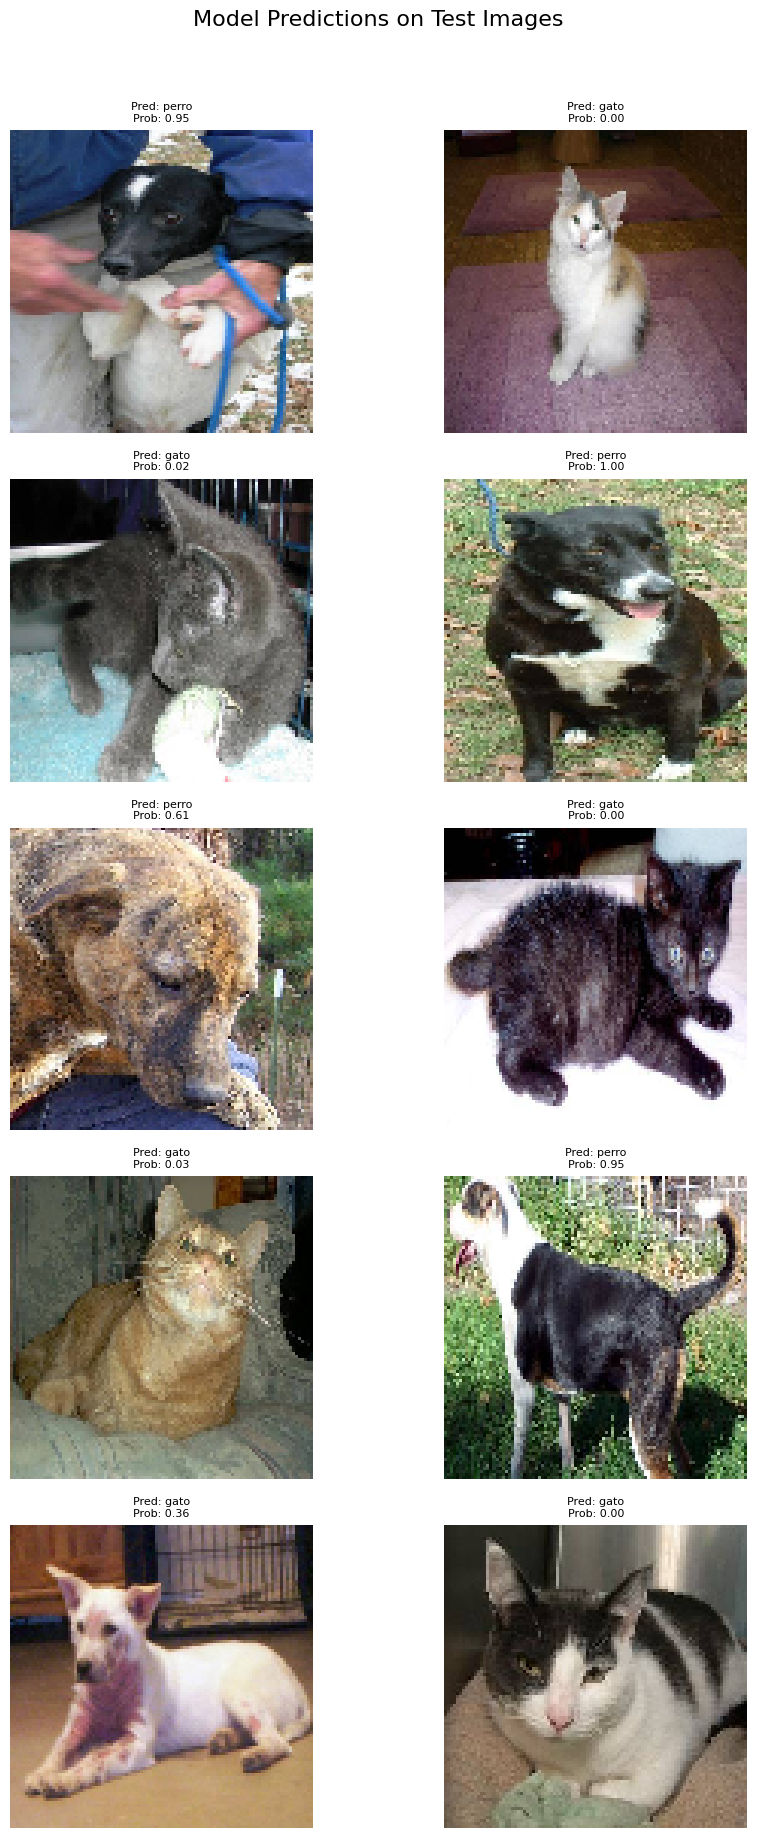

In [18]:
# Visualizing predictions on a subset of test images
images = next(test_generator)  # Obtain a batch of (normalized) images

# Select the first 20 images
n_images = 10
sample_images = images[0][:n_images]  # Images
sample_filenames = filenames[:n_images]  # File names
sample_labels = predicted_labels[:n_images]  # Predicted tags
sample_probs = predictions[:n_images].flatten()  # Odds

# Create image grid
plt.figure(figsize=(10, 18))
plt.rcParams['font.size'] = 12  # Tamaño de fuente base
plt.rcParams['axes.titlesize'] = 14  # Tamaño de títulos
plt.suptitle("Model Predictions on Test Images", fontsize=16, y=1.02)
for i in range(n_images):
    plt.subplot(5, 2, i+1)  # 2x5 grid
    
    # Display image (revert normalization for display)
    img = sample_images[i]
    if img.max() <= 1.0:
        img = img * 255  # Scale back to [0,255]
    plt.imshow(img.astype(np.uint8))
    
    # Add predicted label and probability
    plt.title(f"Pred: {sample_labels[i]}\nProb: {sample_probs[i]:.2f}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()